**NAME** - _Padmanavan Kumar_

**Anomaly Detection in Network Traffic**

Using unsupervised learning techniques such as _isolation forests_ or _autoencoders_ to detect unusual patterns or anomalies in network traffic data, which could indicate potential security breaches or system malfunctions.

Resources :

https://www.kaggle.com/datasets/galaxyh/kdd-cup-1999-data

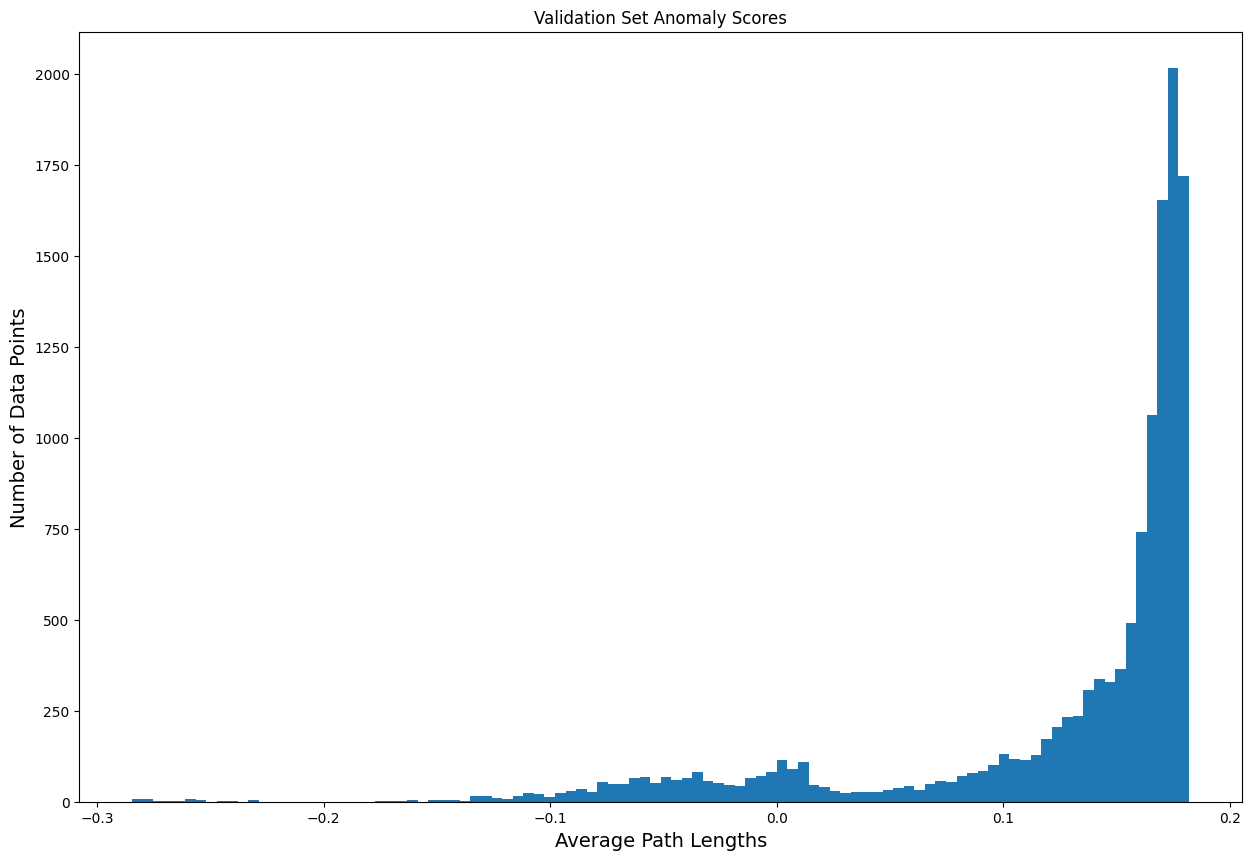

Validation AUC: 53.81%


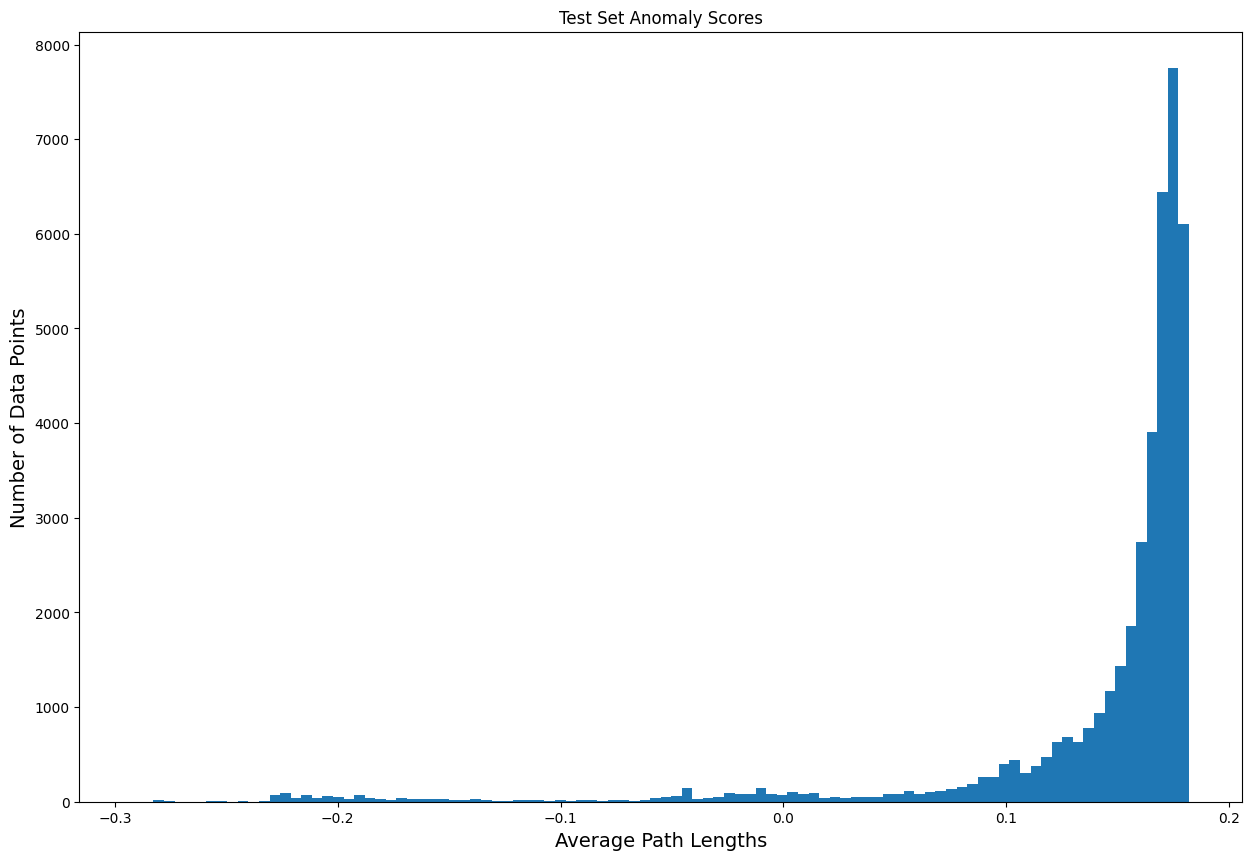

Test AUC: 62.64%


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

# Define the path to your local dataset files
train_data_path = 'kddcup.data_10_percent_corrected'
test_data_path = 'corrected'

# Load the data
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

df = pd.read_csv(train_data_path, header=None, names=column_names)
df_test = pd.read_csv(test_data_path, header=None, names=column_names)

# Filter data to only include HTTP service and drop the service column
df = df[df["service"] == "http"].drop("service", axis=1)
df_test = df_test[df_test["service"] == "http"].drop("service", axis=1)

# Combine training and test data for label encoding
combined_data = pd.concat([df, df_test], axis=0)

# Encode categorical variables
label_encoders = {}
for col in combined_data.columns:
    if combined_data[col].dtype == 'object':
        le = LabelEncoder()
        combined_data[col] = le.fit_transform(combined_data[col])
        df[col] = le.transform(df[col])
        df_test[col] = le.transform(df_test[col])
        label_encoders[col] = le

# Shuffle and split data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

x_train = df_train.drop("label", axis=1)
y_train = df_train["label"]
x_val = df_val.drop("label", axis=1)
y_val = df_val["label"]
x_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

# Train Isolation Forest model
model = IsolationForest(n_estimators=500, max_samples=256, contamination=0.1, random_state=42)
model.fit(x_train)

# Evaluate the model
def plot_histogram(anomaly_scores, title):
    plt.figure(figsize=(15, 10))
    plt.hist(anomaly_scores, bins=100)
    plt.xlabel('Average Path Lengths', fontsize=14)
    plt.ylabel('Number of Data Points', fontsize=14)
    plt.title(title)
    plt.show()

# Validation set
anomaly_scores_val = model.decision_function(x_val)
plot_histogram(anomaly_scores_val, 'Validation Set Anomaly Scores')

# Calculate AUC for validation set
anomalies_val = anomaly_scores_val > -0.19
auc_val = roc_auc_score(y_val == label_encoders["label"].transform(["normal."])[0], anomalies_val)
print(f"Validation AUC: {auc_val:.2%}")

# Test set
anomaly_scores_test = model.decision_function(x_test)
plot_histogram(anomaly_scores_test, 'Test Set Anomaly Scores')

# Calculate AUC for test set
anomalies_test = anomaly_scores_test > -0.19
auc_test = roc_auc_score(y_test == label_encoders["label"].transform(["normal."])[0], anomalies_test)
print(f"Test AUC: {auc_test:.2%}")
